### Kinematic Single-track Dynamics Example

This notebook will lay out an example of using data collected from simulation of the F1/10 cars to create models for the car's behavior

In [1]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, labs
from vehicle_parameters import load_parameters

In [2]:
def import_csv(filenum: int, filename: str):
    input_df = pd.read_csv(f"csv/in_{filename}_{filenum}.csv")
    obs_df = pd.read_csv(f"csv/obs_{filename}_{filenum}.csv")
    deriv_df = pd.read_csv(f"csv/deriv_{filename}_{filenum}.csv")
  
    return obs_df[['time', 'x', 'y', 'steering_angle', 'velocity', 'heading']], input_df[['time', 'steering_velocity', 'acceleration']], deriv_df

num_files = 3
obs = []
inputs = []
derivs = []

for i in range(num_files):
    return_val = import_csv(i, 'kinematic')

    obs.append(return_val[0])
    inputs.append(return_val[1])
    derivs.append(return_val[2])

states_df = obs[1]
input_df = inputs[1]
deriv_df = derivs[1]
states_df

,time,x,y,steering_angle,velocity,heading
0,0.00,-0.213317,-0.075379,0.002982,0.064132,0.207465
1,0.01,-0.212689,-0.075247,0.002982,0.064139,0.207470
2,0.02,-0.212062,-0.075115,0.002982,0.064153,0.207476
3,0.03,-0.211434,-0.074983,0.002981,0.064173,0.207482
4,0.04,-0.210806,-0.074851,0.002980,0.064200,0.207488
...,...,...,...,...,...,...
996,9.96,5.408549,0.663868,-0.002220,1.077369,0.064056
997,9.97,5.419305,0.664557,-0.002187,1.078230,0.063984
998,9.98,5.430070,0.665247,-0.002155,1.079091,0.063913
999,9.99,5.440843,0.665936,-0.002123,1.079952,0.063843


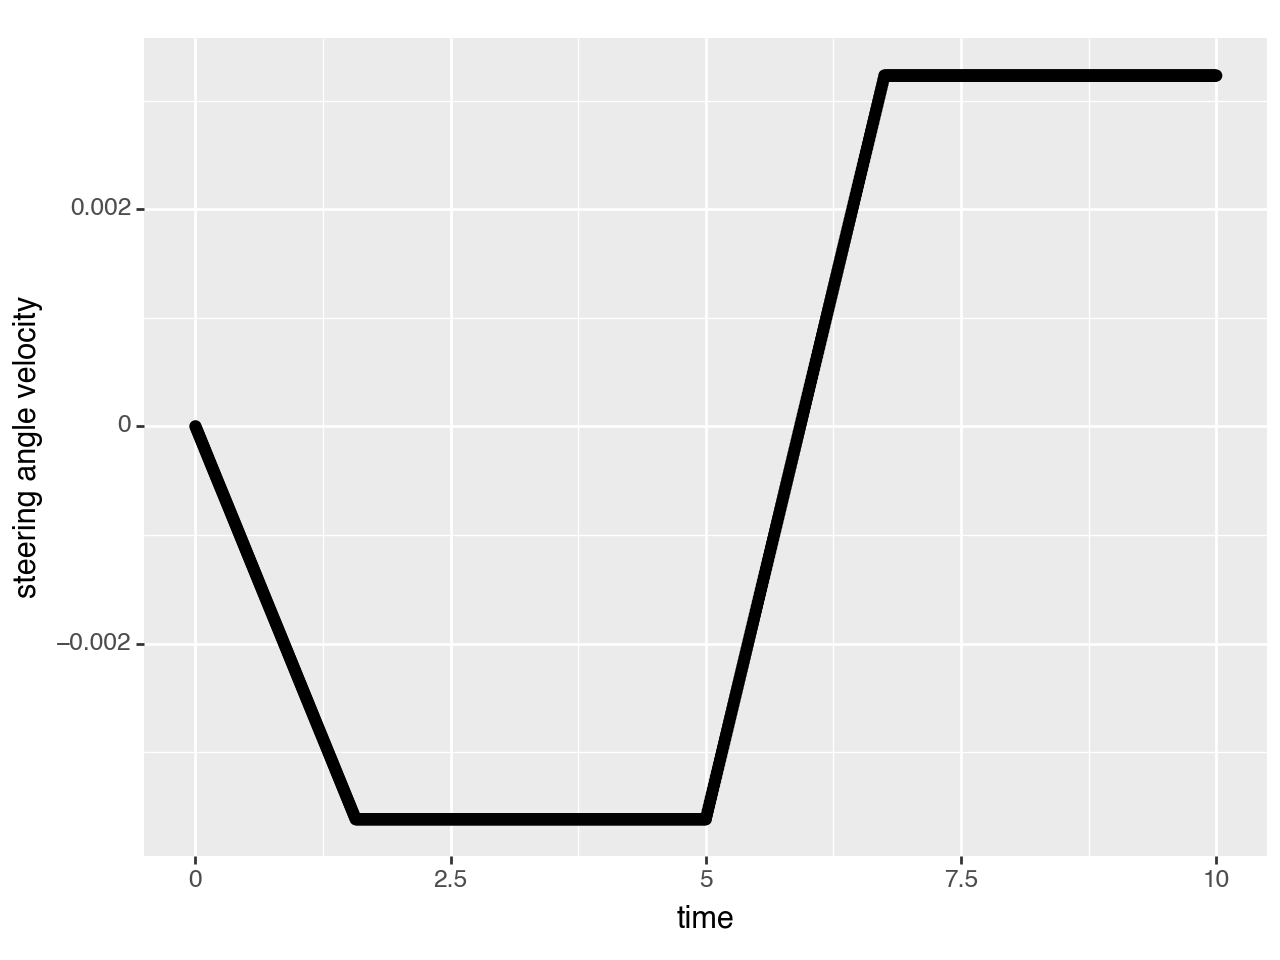

<Figure Size: (640 x 480)>

In [3]:
(
    ggplot(input_df, aes(x='time', y='steering_velocity')) 
    + geom_point() 
    + labs(x="time", y="steering angle velocity")
) 

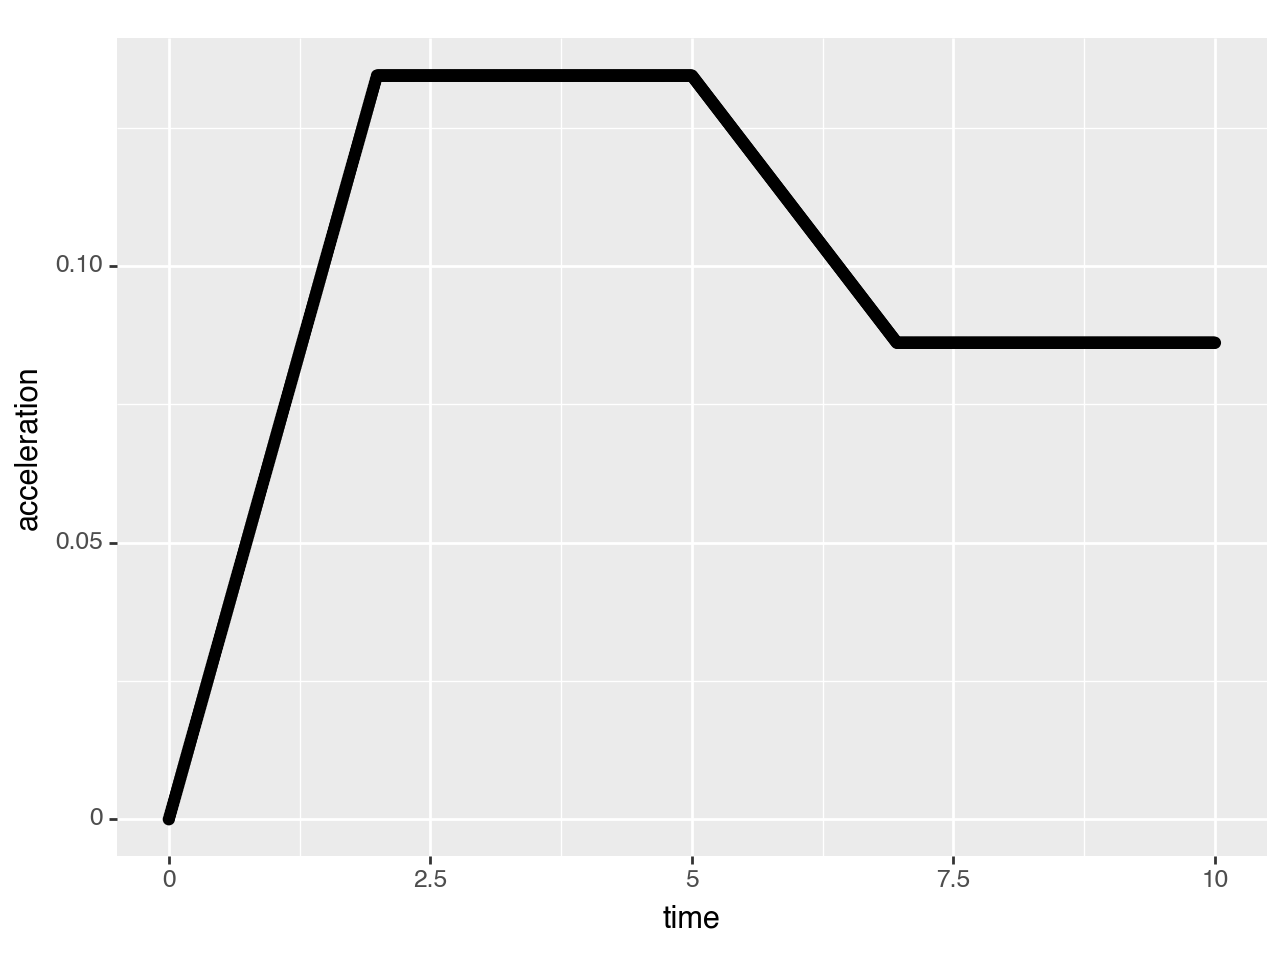

<Figure Size: (640 x 480)>

In [4]:
(
    ggplot(input_df, aes(x='time', y='acceleration')) 
    + geom_point()
    + labs(x="time", y="acceleration")
)

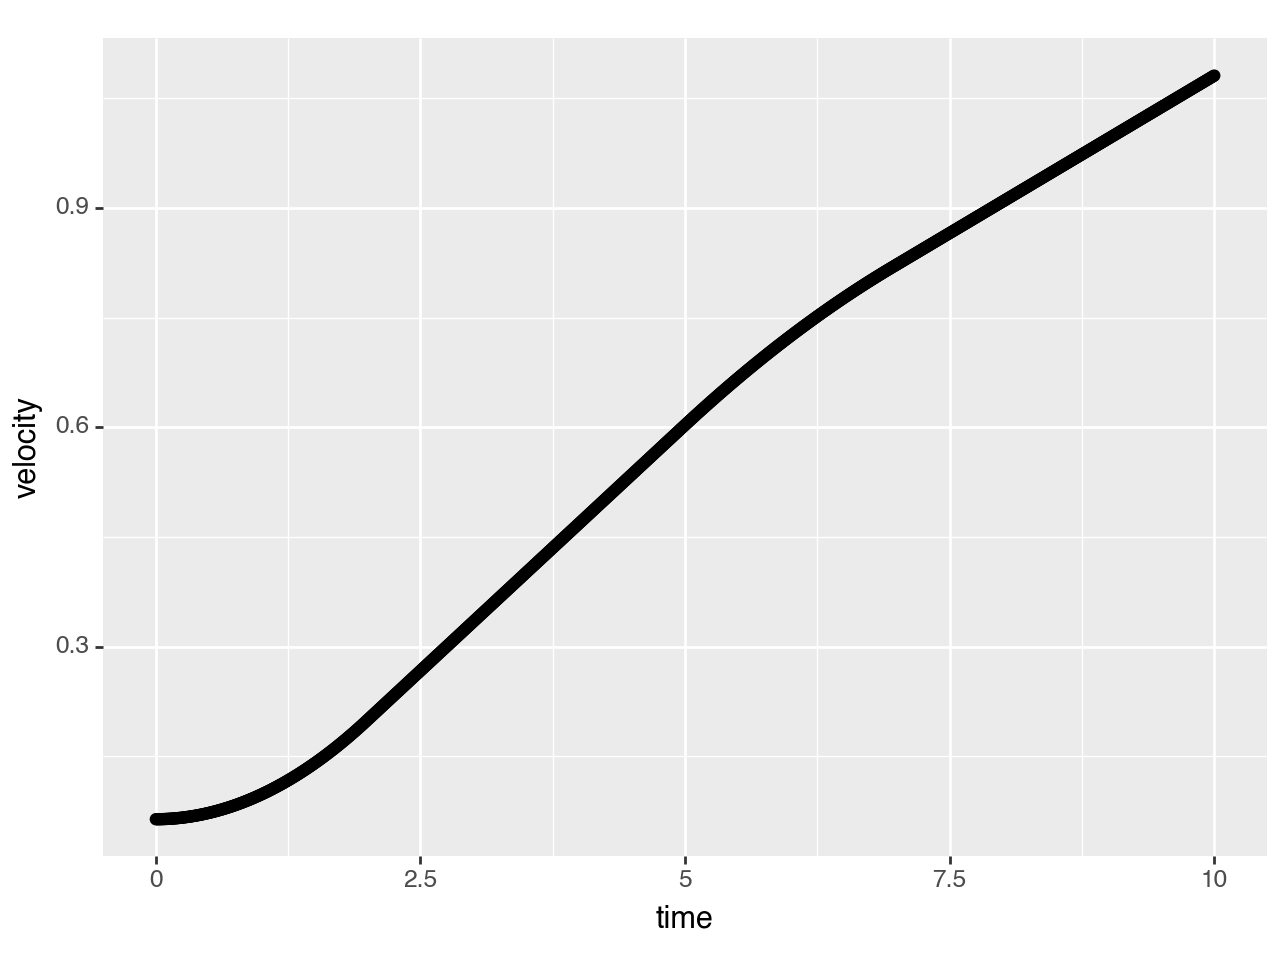

<Figure Size: (640 x 480)>

In [5]:
(
    ggplot(states_df, aes(x='time', y='velocity')) 
    + geom_point()
    + labs(x="time", y="velocity")
)

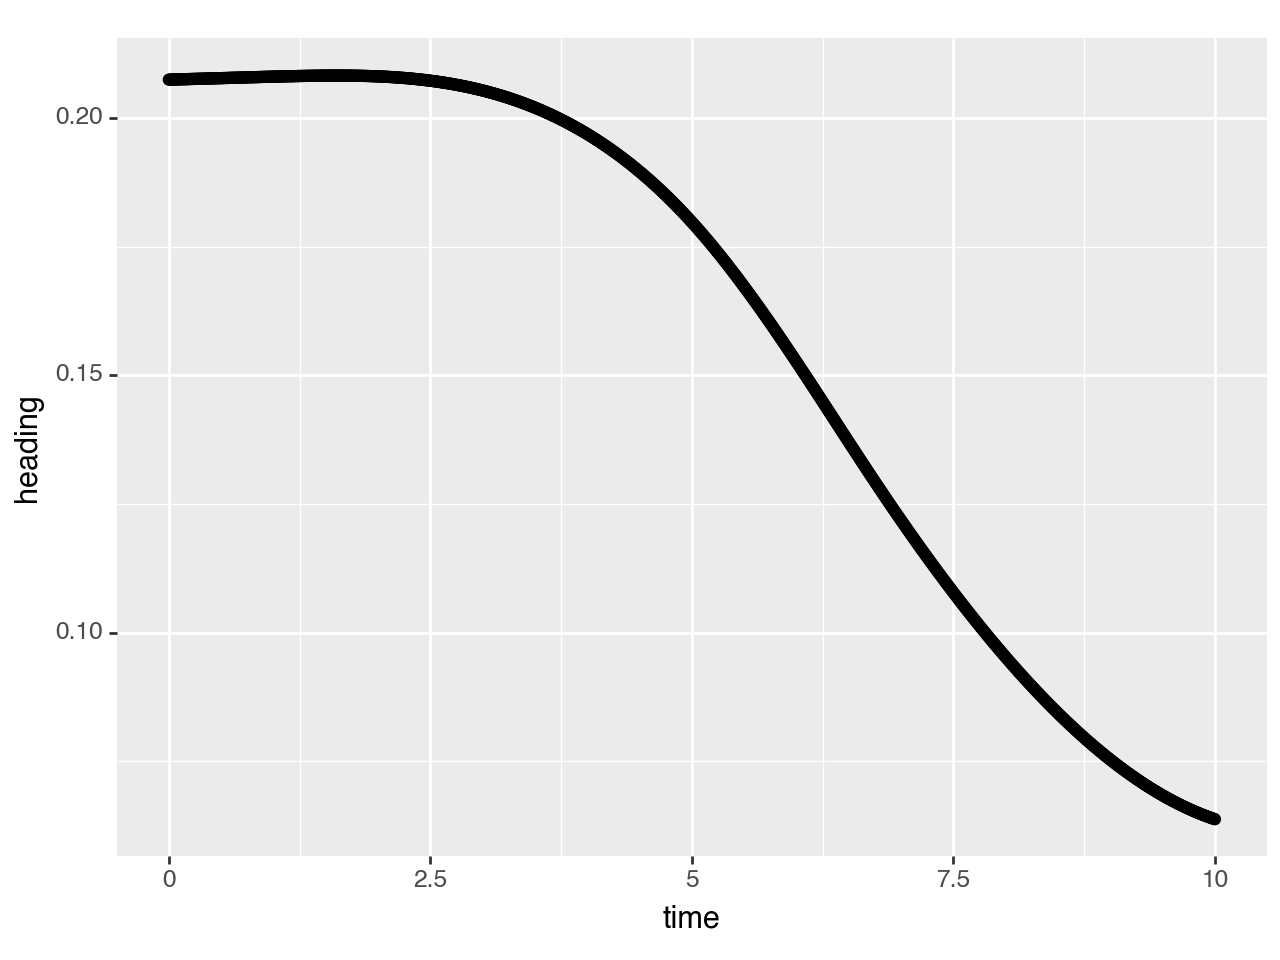

<Figure Size: (640 x 480)>

In [6]:
(
    ggplot(states_df, aes(x='time', y='heading')) 
    + geom_point()
    + labs(x="time", y="heading")
)

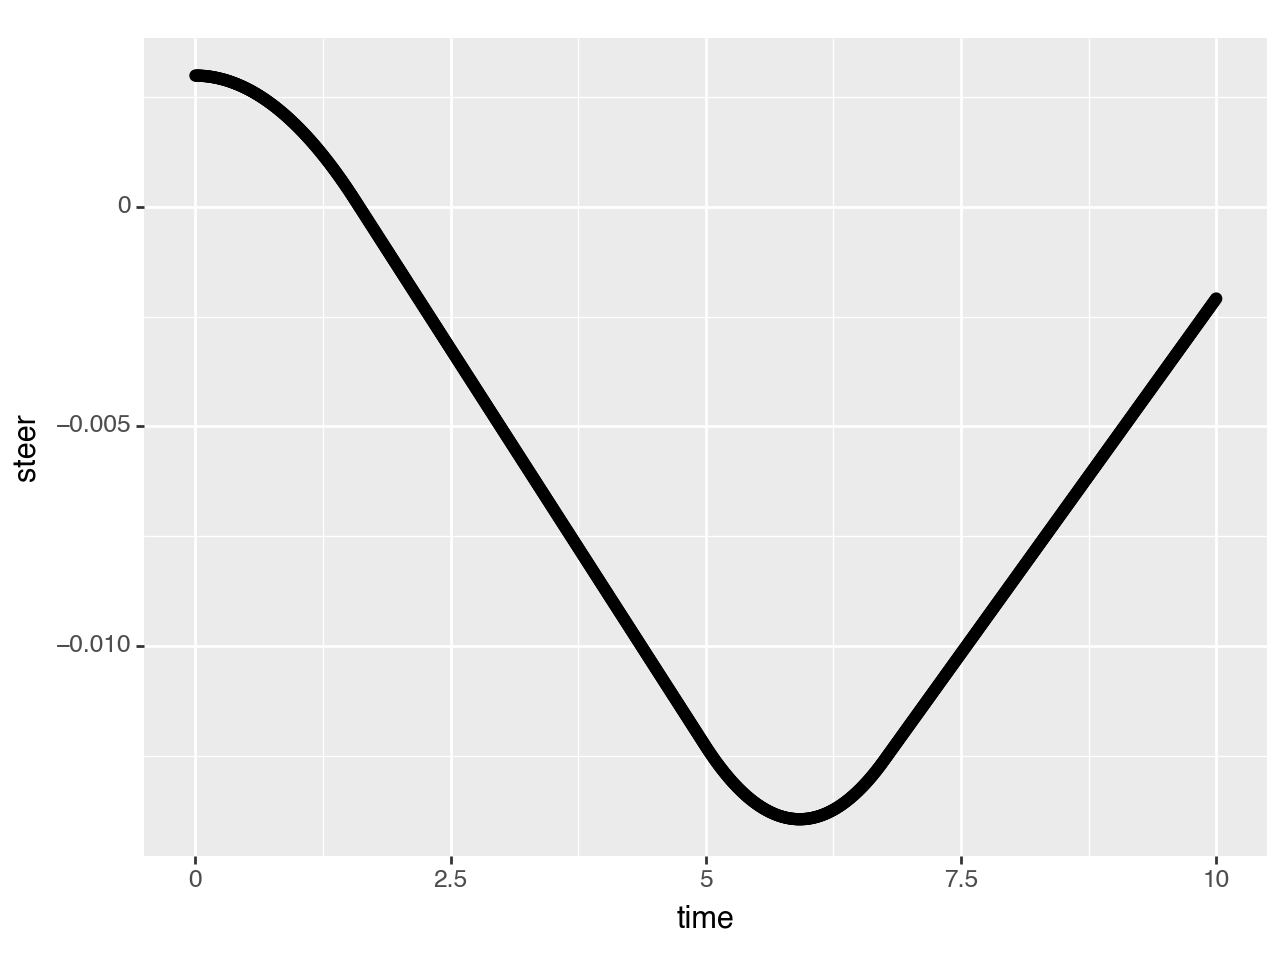

<Figure Size: (640 x 480)>

In [7]:
(
    ggplot(states_df, aes(x='time', y='steering_angle')) 
    + geom_point()
    + labs(x="time", y="steer")
)

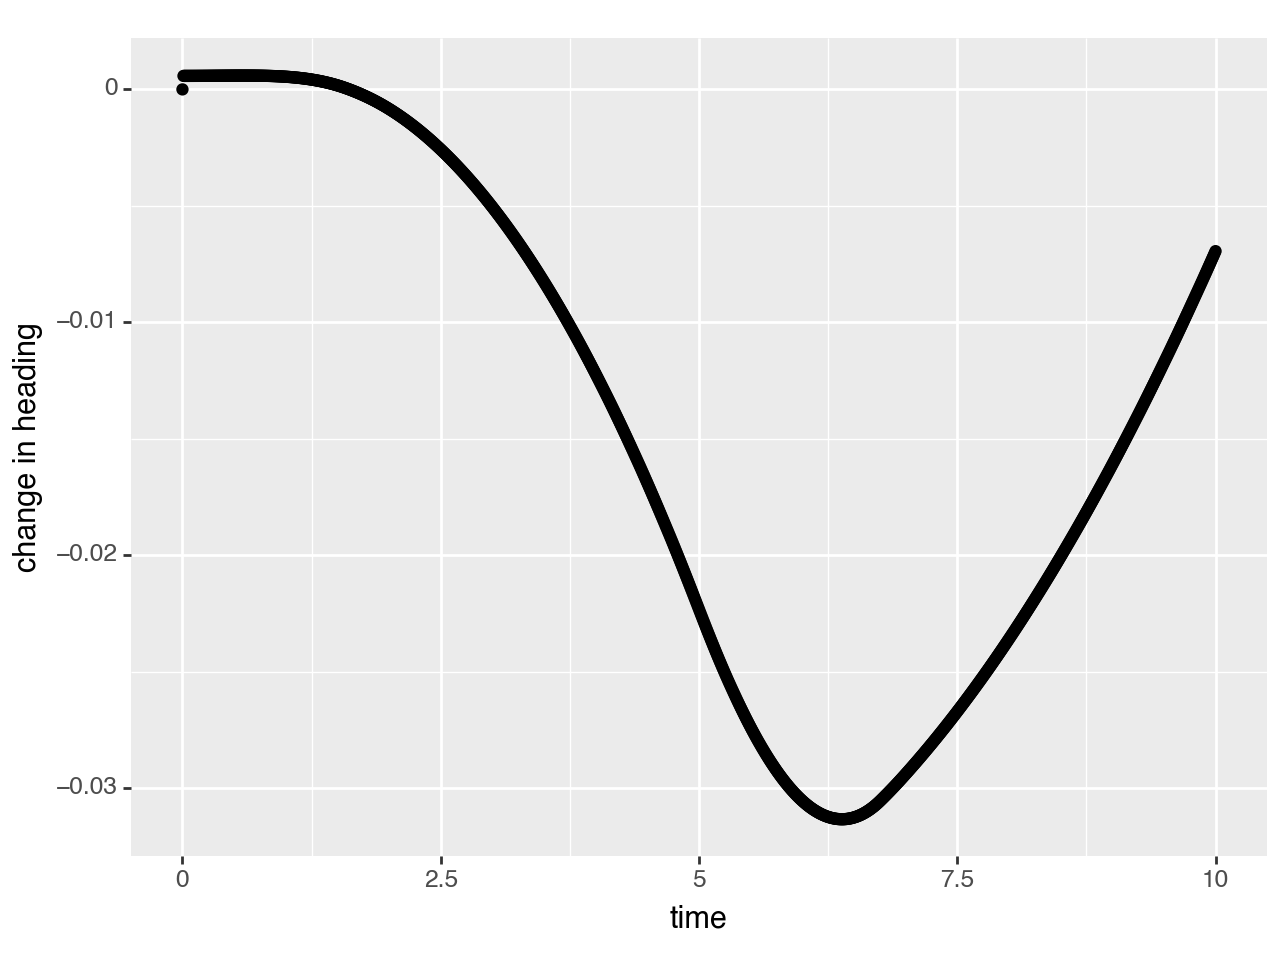

<Figure Size: (640 x 480)>

In [8]:
(
    ggplot(deriv_df, aes(x='time', y='heading')) 
    + geom_point()
    + labs(x="time", y="change in heading")
)

### Physics Model

Our training data has been generated with by a simulator using the following ODE:

$$
\dot{x} = vcos{(\psi)}
$$
$$
\dot{y} = vsin{(\psi)}
$$
$$
\dot{v} = a
$$
$$
\dot{\psi} = \frac{v}{l_{wb}}tan{(\delta)}
$$
$$
\dot{\delta} = v_\delta
$$

More information about these physics can be found [here](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf?ref_type=heads).

### Neuromancer Setup

We will create a NeuralODE, which will aim to learn these governing equations from the data. To do this, we will use the neuromancer library

In [9]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

In [10]:
n_obs = 1000

train_X = obs[2][:n_obs]
test_X = obs[1][:n_obs]
dev_X = obs[0][:n_obs]


train_U = inputs[2][:n_obs]
test_U = inputs[1][:n_obs]
dev_U = inputs[0][:n_obs]
train_X

,time,x,y,steering_angle,velocity,heading
0,0.00,-0.248875,0.090374,0.003530,0.153366,-0.129291
1,0.01,-0.247354,0.090176,0.003530,0.153370,-0.129275
2,0.02,-0.245833,0.089978,0.003531,0.153378,-0.129258
3,0.03,-0.244312,0.089781,0.003532,0.153389,-0.129242
4,0.04,-0.242791,0.089583,0.003533,0.153405,-0.129226
...,...,...,...,...,...,...
995,9.95,4.782992,0.200007,0.026641,1.054094,0.217857
996,9.96,4.793289,0.202291,0.026642,1.055392,0.218708
997,9.97,4.803597,0.204587,0.026644,1.056690,0.219560
998,9.98,4.813915,0.206894,0.026645,1.057989,0.220414


In [11]:
def normalize(x):    
    return (x - x.mean(axis=0)) / x.std(axis=0)

nsteps = 2
bs = 50

def get_data(nsteps, bs, dropX, dropU): 

    trainX = train_X.drop(columns=dropX).reset_index(drop=True)
    nbatch = trainX.shape[0]//nsteps
    length = (trainX.shape[0]//nsteps) * nsteps

    nx = trainX.shape[1]
    trainX = trainX.to_numpy()
    trainX = normalize(trainX)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    
    trainU = train_U.drop(columns=dropU).reset_index(drop=True)
    nu = trainU.shape[1]
    trainU = trainU.to_numpy()
    trainU = normalize(trainU)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    
    devX = dev_X.drop(columns=dropX).reset_index(drop=True)
    devX = devX.to_numpy()
    devX = normalize(devX)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    
    devU = dev_U.drop(columns=dropU).reset_index(drop=True)
    devU = devU[:length].to_numpy()
    devU = normalize(devU)
    devU = devU.reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    
    testX = test_X.drop(columns=dropX).reset_index(drop=True)
    testX = testX.to_numpy()
    testX = normalize(testX)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    
    testU = test_U.drop(columns=dropU).reset_index(drop=True)
    testU = testU.to_numpy()
    testU = normalize(testU)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)

    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    
    test_data = {'X': testX, 'xn': testX[:, 0:1, :],
                 'U': testU}

    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    return train_loader, dev_loader, test_data, nx, nu

train_loader, dev_loader, test_data, nx, nu = get_data(nsteps, bs, ['time', 'x', 'y'], ['time'])

In [12]:
fx = blocks.MLP(nx+nu, nx, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=[80, 80, 80])

In [13]:
fxInt = integrators.DiffEqIntegrator(fx, h=0.001, method='euler')

In [14]:
model = Node(fxInt, ['xn', 'U'], ['xn'], name='NODE')
dynamics_model = System([model], name='system', nsteps=nsteps)

In [15]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]
steering = variable('xn')[:, :, [0]]
velocity = variable('xn')[:, :, [1]]

# trajectory tracking loss
reference_loss = 1.*(xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

In [16]:
objectives = [reference_loss, onestep_loss]
constraints = []

loss = PenaltyLoss(objectives, constraints)

problem = Problem([dynamics_model], loss)

In [17]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.0075)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])
# define neuromancer trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=50,
    epochs=100,
    eval_metric="dev_loss",
    train_metric="train_loss",
    test_metric="test_loss",
    dev_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 13683


In [18]:
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 0.00001	dev_loss: 0.00005	eltime:  0.15425
epoch: 1	train_loss: 0.00000	dev_loss: 0.00005	eltime:  0.29509
epoch: 2	train_loss: 0.00000	dev_loss: 0.00005	eltime:  0.40835
epoch: 3	train_loss: 0.00000	dev_loss: 0.00005	eltime:  0.55267
epoch: 4	train_loss: 0.00000	dev_loss: 0.00005	eltime:  0.66760
epoch: 5	train_loss: 0.00000	dev_loss: 0.00006	eltime:  0.82213
epoch: 6	train_loss: 0.00000	dev_loss: 0.00005	eltime:  0.98053
epoch: 7	train_loss: 0.00000	dev_loss: 0.00005	eltime:  1.09942
epoch: 8	train_loss: 0.00000	dev_loss: 0.00005	eltime:  1.26113
epoch: 9	train_loss: 0.00000	dev_loss: 0.00005	eltime:  1.38760
epoch: 10	train_loss: 0.00000	dev_loss: 0.00005	eltime:  1.52780
epoch: 11	train_loss: 0.00000	dev_loss: 0.00005	eltime:  1.66184
epoch: 12	train_loss: 0.00000	dev_loss: 0.00006	eltime:  1.78780
epoch: 13	train_loss: 0.00000	dev_loss: 0.00004	eltime:  1.97763
epoch: 14	train_loss: 0.00000	dev_loss: 0.00005	eltime:  2.11839
epoch: 15	train_loss: 0.00000	dev_l

<All keys matched successfully>

In [19]:
dynamics_model.nsteps = test_data['X'].shape[1]

In [20]:
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)

In [21]:
true_df = pd.DataFrame(data=true_traj)
true_df = true_df.rename(columns={0: 'steering_angle', 1: 'velocity', 2: 'heading'})
true_df = true_df.assign(time=obs[1][['time']][:n_obs].values)
true_df = true_df.assign(source="observed")

pred_df = pd.DataFrame(data=pred_traj)
pred_df = pred_df.rename(columns={0: 'steering_angle', 1: 'velocity', 2: 'heading'})
pred_df = pred_df.assign(time=obs[1][['time']][:n_obs].values)
pred_df = pred_df.assign(source="node")

In [22]:
combined_df = pd.concat([true_df, pred_df])

combined_df

,steering_angle,velocity,heading,time,source
0,1.802173,-1.558162,0.953847,0.00,observed
1,1.802129,-1.558141,0.953959,0.01,observed
2,1.802042,-1.558100,0.954071,0.02,observed
3,1.801911,-1.558038,0.954182,0.03,observed
4,1.801735,-1.557955,0.954294,0.04,observed
...,...,...,...,...,...
995,2.738260,4.844006,11.483219,9.95,node
996,2.739587,4.854256,11.503663,9.96,node
997,2.740913,4.864520,11.524138,9.97,node
998,2.742240,4.874798,11.544645,9.98,node


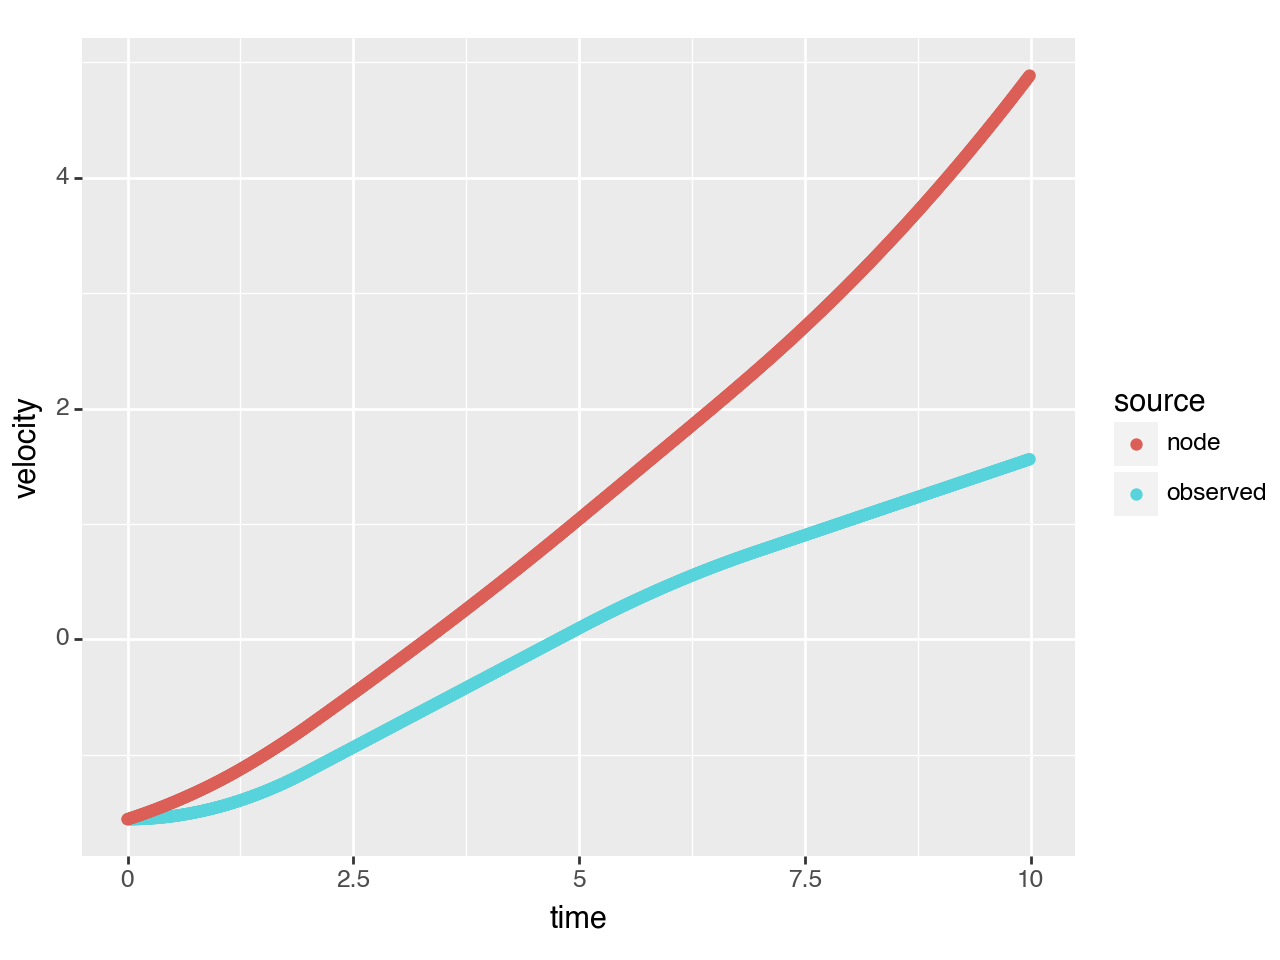

<Figure Size: (640 x 480)>

In [23]:
(ggplot(combined_df, aes(x='time', y='velocity', color='source')) +
 geom_point())

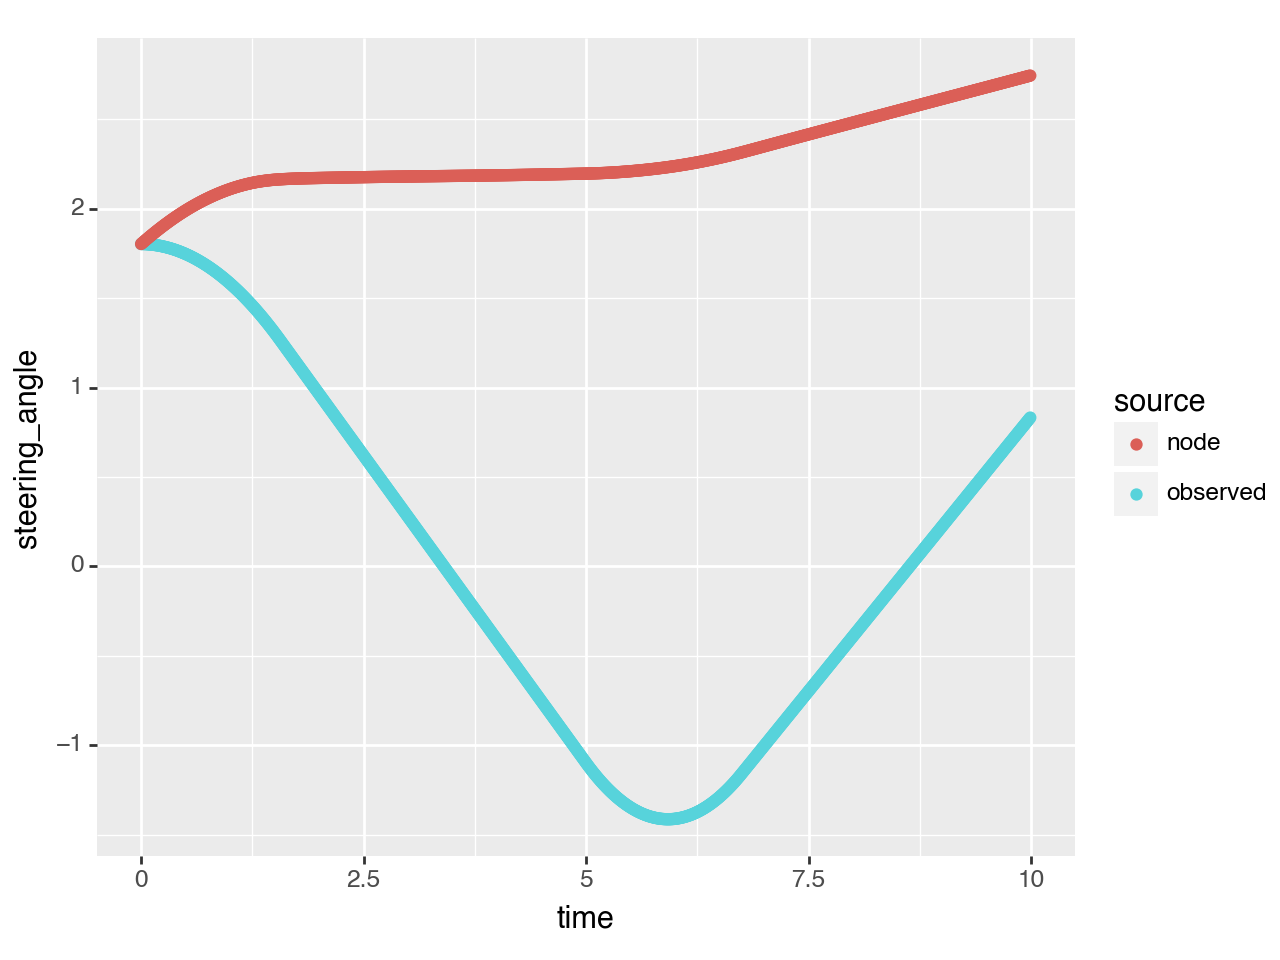

<Figure Size: (640 x 480)>

In [24]:
(ggplot(combined_df, aes(x='time', y='steering_angle', color='source')) +
 geom_point())

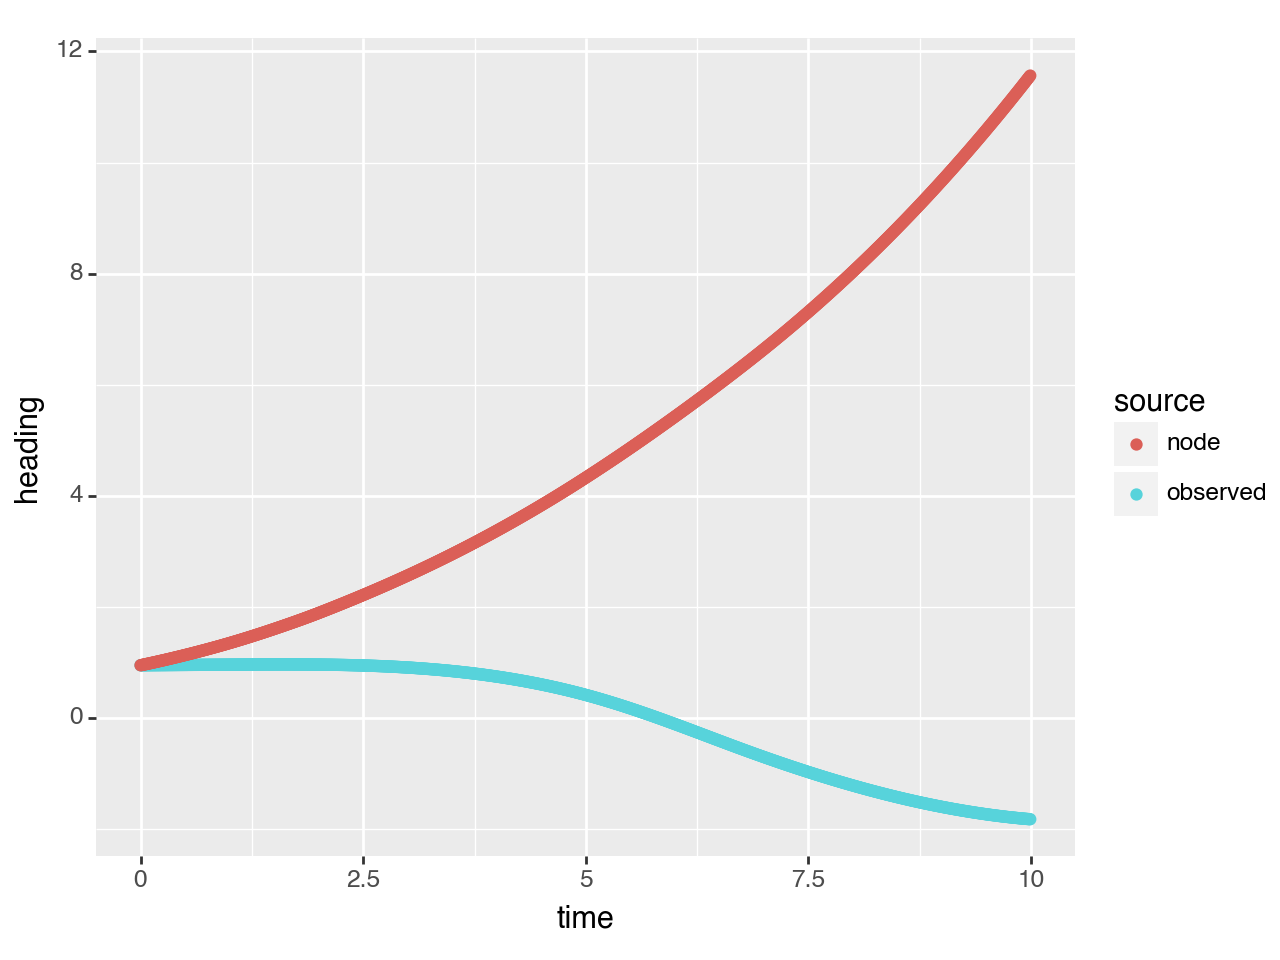

<Figure Size: (640 x 480)>

In [25]:
(ggplot(combined_df, aes(x='time', y='heading', color='source')) +
 geom_point())

### SINDy

Next, we are going to use Sparse Identification of Nonlinear Dynamics to learn the governing equations for this system

In [26]:
from pysindy.feature_library import FourierLibrary, PolynomialLibrary
from pysindy.feature_library import GeneralizedLibrary, CustomLibrary, ConcatLibrary
from scipy.interpolate import LinearNDInterpolator
import pysindy as ps

In [27]:
lib_fourier = FourierLibrary()
lib_polynomial = PolynomialLibrary()
lib_concat = ConcatLibrary([lib_fourier, lib_polynomial])

model = ps.SINDy(feature_library = lib_concat)

t = train_X[['time']].to_numpy()

In [28]:
x = train_X.drop(columns=["time", 'x', 'y']).to_numpy()
u = train_U.drop(columns=["time"])
x = normalize(x)
u = u.to_numpy()
u = normalize(u)
xdot = derivs[2][:n_obs].drop(columns=["time", 'x', 'y']).to_numpy()
xdot = normalize(xdot)

In [29]:
t.flatten()

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [30]:
model.fit(x, t, xdot, u)

model.print()

(x0)' = 1.000 u0
(x1)' = 1.000 u1
(x2)' = 0.192 sin(1 x0) + 0.310 sin(1 x1) + 0.135 x0 + 0.538 x2


In [31]:
x = test_X.drop(columns=["time", 'x', 'y']).to_numpy()
u = test_U.drop(columns=["time"])
x = normalize(x)
u = u.to_numpy()
u = normalize(u)
xmodel = model.simulate(x[0,:], t.flatten(), u , integrator="odeint", )#interpolator=interp_func)#, integrator_kws={'method': 'RK45'})

In [32]:
sindy_df = pd.DataFrame(data=xmodel)
sindy_df = sindy_df.assign(time=t[0:-1])
sindy_df = sindy_df.rename(columns={0: 'steering_angle', 1: 'velocity', 2: 'heading'})
sindy_df = sindy_df.assign(source='sindy')

In [33]:
sindy_df

,steering_angle,velocity,heading,time,source
0,1.802173,-1.558162,0.953847,0.00,sindy
1,1.803838,-1.590342,0.960216,0.01,sindy
2,1.805425,-1.622307,0.966622,0.02,sindy
3,1.806936,-1.654057,0.973069,0.03,sindy
4,1.808370,-1.685593,0.979561,0.04,sindy
...,...,...,...,...,...
994,1.732696,-1.514967,271.764888,9.94,sindy
995,1.745172,-1.519882,273.232613,9.95,sindy
996,1.757649,-1.524797,274.708270,9.96,sindy
997,1.770125,-1.529712,276.191903,9.97,sindy


In [34]:
combined_df = pd.concat([true_df, pred_df, sindy_df])

combined_df

,steering_angle,velocity,heading,time,source
0,1.802173,-1.558162,0.953847,0.00,observed
1,1.802129,-1.558141,0.953959,0.01,observed
2,1.802042,-1.558100,0.954071,0.02,observed
3,1.801911,-1.558038,0.954182,0.03,observed
4,1.801735,-1.557955,0.954294,0.04,observed
...,...,...,...,...,...
994,1.732696,-1.514967,271.764888,9.94,sindy
995,1.745172,-1.519882,273.232613,9.95,sindy
996,1.757649,-1.524797,274.708270,9.96,sindy
997,1.770125,-1.529712,276.191903,9.97,sindy


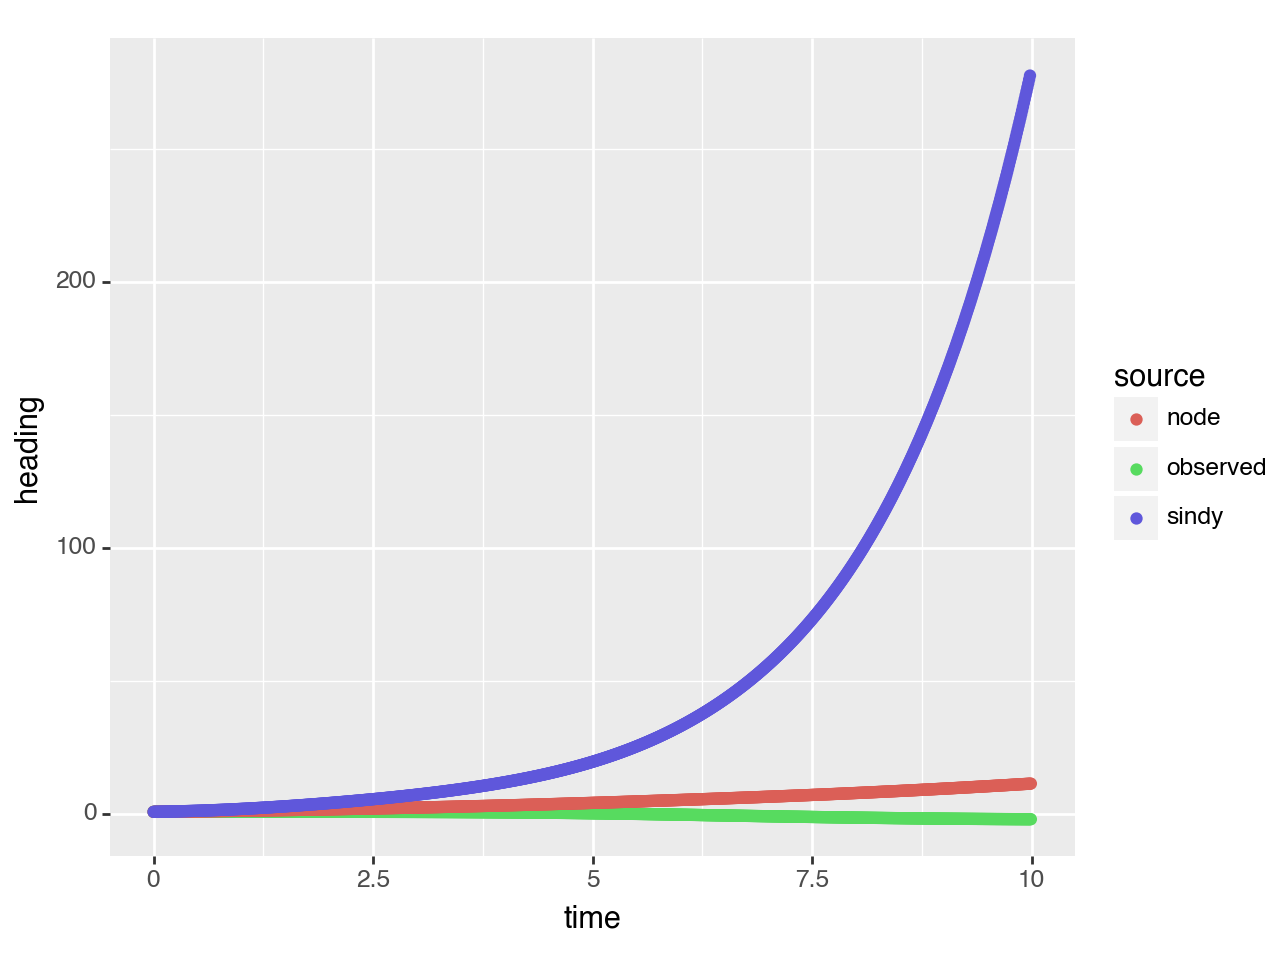

<Figure Size: (640 x 480)>

In [35]:
(ggplot(combined_df, aes(x='time', y='heading', color='source')) +
 geom_point())

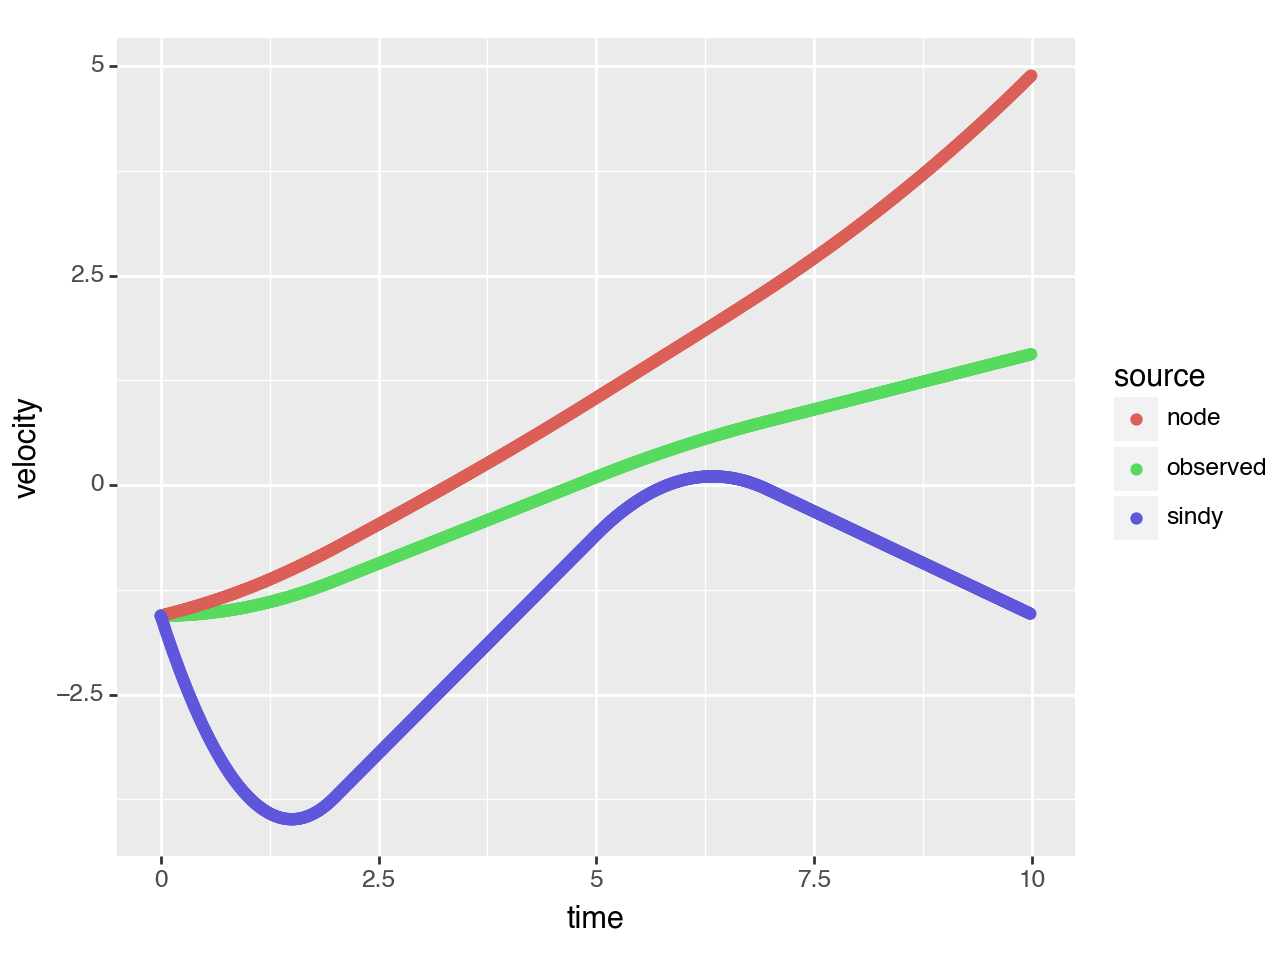

<Figure Size: (640 x 480)>

In [36]:
(ggplot(combined_df, aes(x='time', y='velocity', color='source')) +
 geom_point())

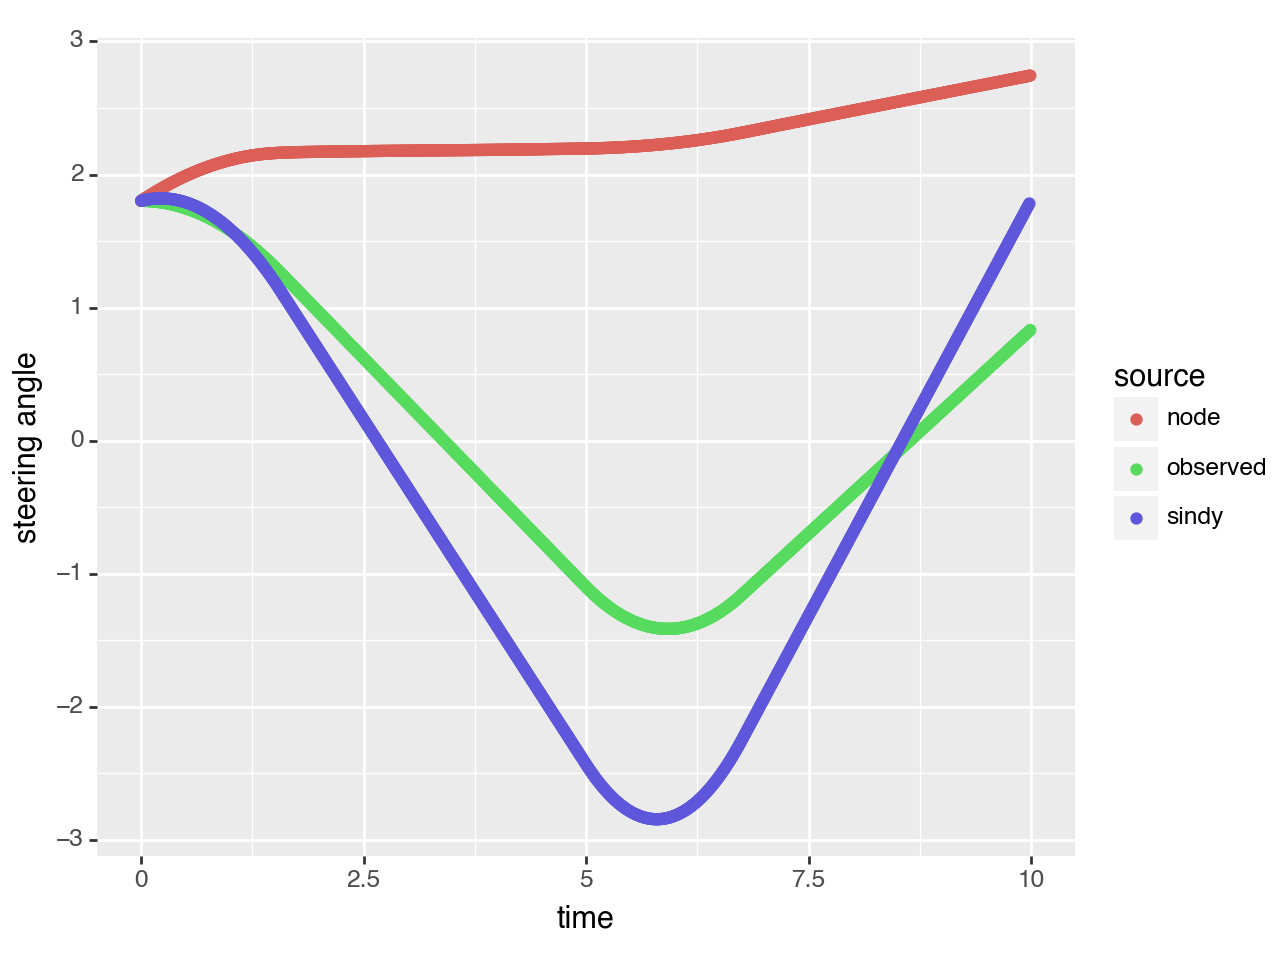

<Figure Size: (640 x 480)>

In [37]:
(ggplot(combined_df, aes(x='time', y='steering_angle', color='source')) +
 geom_point() + labs(x="time", y="steering angle"))

In [38]:
def MSE(pred_df, true_df):
    pred = pred_df.drop(columns=["time", "source"]).to_numpy()
    true = true_df.drop(columns=["time", "source"]).to_numpy()

    return np.sum((pred - true) ** 2) / n_obs
    

In [39]:
MSE(sindy_df, true_df[0:-1])

7347.469793223952

In [40]:
MSE(pred_df, true_df)

49.27005859375